**Описание проекта**


Вы — маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Ваша задача — разобраться в причинах и помочь компании выйти в плюс.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

Вам предстоит изучить:
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

## Загрузим данные и подготовим их к анализу

### Загрузим библиотеки и датасеты

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [2]:
visits = pd.read_csv('visits_info_short.csv')
orders = pd.read_csv('orders_info_short.csv')
costs = pd.read_csv('costs_info_short.csv')

In [3]:
visits.head()

User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


Больше 300 тыс. строк записей о посещениях пользователей. У дат тип данных object. 

In [5]:
orders.head()

User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


Более 40 тыс. записей о заказах пользователей. Даты снова в виде object.

In [7]:
costs.head()

dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

In [8]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


1800 записей о расходах на рекламу. Даты снова object.

Пропусков нет ни в одном из датасетов.

### Предобработка данных

Проверим данные на наличие дубликатов.

In [9]:
print(visits.duplicated().sum(),orders.duplicated().sum(),costs.duplicated().sum())

0 0 0


Явных дубликатов нет. Теперь приведём названия столбцов к единому стилю - без заглавных букв и пробелов.

In [10]:
visits.columns = [x.lower().replace(' ', '_') for x in visits.columns]
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns]
costs.columns = [x.lower().replace(' ', '_') for x in costs.columns]

Исправим тип данных для столбцов с временными значениями.

In [11]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [12]:
print(visits.info(), orders.info(), costs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.

Данные хорошо структурированы, мы не обнаружили дубликатов, привели названия к одному стилю и изменили тип данных на datetime там, где требовалось. Можно двигаться дальше.

## Задайте функции для расчёта и анализа LTV, ROI, удержания и конверсии.

### Функция создания профиля пользователей

In [29]:
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].dt.to_period('M').dt.to_timestamp()

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

### Функция для подсчета доли удержания (ретеншен)

In [14]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Функция для подсчета конверсии

In [15]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Функция для расчёта LTV и ROI

In [16]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    ltv_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    ltv_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        ltv_grouped,  # таблица LTV
        ltv_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

### Функция для сглаживания данных

In [17]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

### Функция для визуализации удержания

In [18]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

### Функция для визуализации конверсии

In [19]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Функция для визуализации LTV и ROI

In [20]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

Функции готовы, теперь можно заняться анализом.

## Исследовательский анализ данных

### Профили пользователей

Составим профили пользователей и определим мин и макс даты привлечения.

In [30]:
profiles = get_profiles(visits, orders, costs)
print(profiles.head())

    user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769  


In [33]:
min_acq_date = profiles['dt'].min()
max_acq_date = profiles['dt'].max()

print('Минимальная дата привлечения: ',min_acq_date, '\nМаксимальная дата привлечения: ', max_acq_date)

Минимальная дата привлечения:  2019-05-01 
Максимальная дата привлечения:  2019-10-27


Датафрейм с профилями готов. Границы дат совпадают с тем, что было сказано в тз.

### Страны

Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей.
Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [43]:
regions = (profiles.groupby('region')
           .agg({'user_id':'nunique', 'payer':['sum','mean']})
           .sort_values(('user_id', 'nunique'), ascending=False))
print(regions)

              user_id payer          
              nunique   sum      mean
region                               
United States  100002  6902  0.069019
UK              17575   700  0.039829
France          17450   663  0.037994
Germany         14981   616  0.041119


Америка на первом месте. Пользователей оттуда в 2 раза больше, чем из остальных источников совокупно, то есть примерн 66%. К тому же доля платящих там заметно выше. Почти 7% против примерно 4% у остальных.

### Устройства

Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [51]:
devices = (profiles.groupby('device')
           .agg({'user_id':'nunique', 'payer':['sum','mean']})
           .sort_values(('user_id', 'nunique'), ascending=False))
print(devices)

        user_id payer          
        nunique   sum      mean
device                         
iPhone    54479  3382  0.062079
Android   35032  2050  0.058518
PC        30455  1537  0.050468
Mac       30042  1912  0.063644


Больше всего пользователей сидят с айфонов. С андроидов сидят в 1.5 раза меньше пользователей. Ещё пользователей PC и Mac. По проценту платящих лучше всего Mac - 6.4%, затем Iphone - 6.2%, Android - 5.9% и затем PC - 5%.

### Каналы привлечения

Определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [52]:
channels = (profiles.groupby('channel')
           .agg({'user_id':'nunique', 'payer':['sum','mean']})
           .sort_values(('user_id', 'nunique'), ascending=False))
print(channels)

                   user_id payer          
                   nunique   sum      mean
channel                                   
organic              56439  1160  0.020553
FaceBoom             29144  3557  0.122049
TipTop               19561  1878  0.096007
OppleCreativeMedia    8605   233  0.027077
LeapBob               8553   262  0.030633
WahooNetBanner        8553   453  0.052964
RocketSuperAds        4448   352  0.079137
MediaTornado          4364   156  0.035747
YRabbit               4312   165  0.038265
AdNonSense            3880   440  0.113402
lambdaMediaAds        2149   225  0.104700


В тройке лидеров органический трафик, затем FaceBoom и TipTop. По доле платящих органика на последнем месте(2%). На 1 месте - Faceboom(12%) и на 4 - Tiptop(10%). На 2 - AdNonSense(11%) и на 3 - lambdaMediaAds(10%) - по объёму трафика они в конце списка, но конвертируются отлично.

## Маркетинг

### Расходы на маркетинг

Посчитаем общую сумму расходов на маркетинг.

In [54]:
print(costs)

              dt         channel  costs
0     2019-05-01        FaceBoom  113.3
1     2019-05-02        FaceBoom   78.1
2     2019-05-03        FaceBoom   85.8
3     2019-05-04        FaceBoom  136.4
4     2019-05-05        FaceBoom  122.1
...          ...             ...    ...
1795  2019-10-23  lambdaMediaAds    4.0
1796  2019-10-24  lambdaMediaAds    6.4
1797  2019-10-25  lambdaMediaAds    8.8
1798  2019-10-26  lambdaMediaAds    8.8
1799  2019-10-27  lambdaMediaAds   12.0

[1800 rows x 3 columns]


In [55]:
print(costs['costs'].sum())

105497.30000000002


Теперь рассчитаем траты по источникам.

In [58]:
print(costs.groupby('channel').agg({'costs':'sum'}).sort_values('costs', ascending=False))

                       costs
channel                     
TipTop              54751.30
FaceBoom            32445.60
WahooNetBanner       5151.00
AdNonSense           3911.25
OppleCreativeMedia   2151.25
RocketSuperAds       1833.00
LeapBob              1797.60
lambdaMediaAds       1557.60
MediaTornado          954.48
YRabbit               944.22


Самые большие траты на TipTop и FaceBoom. Неудивительно, учитывая, сколько трафика к нам пришло оттуда.

### Визуализация 

Построим график с визуализацией динамики изменения расходов во времени по неделям по каждому источнику.

Добавим столбец 'week' для группировки.

In [82]:
costs['dt'] = pd.to_datetime(costs['dt'])
costs['week'] = costs['dt'].dt.to_period('W').dt.start_time

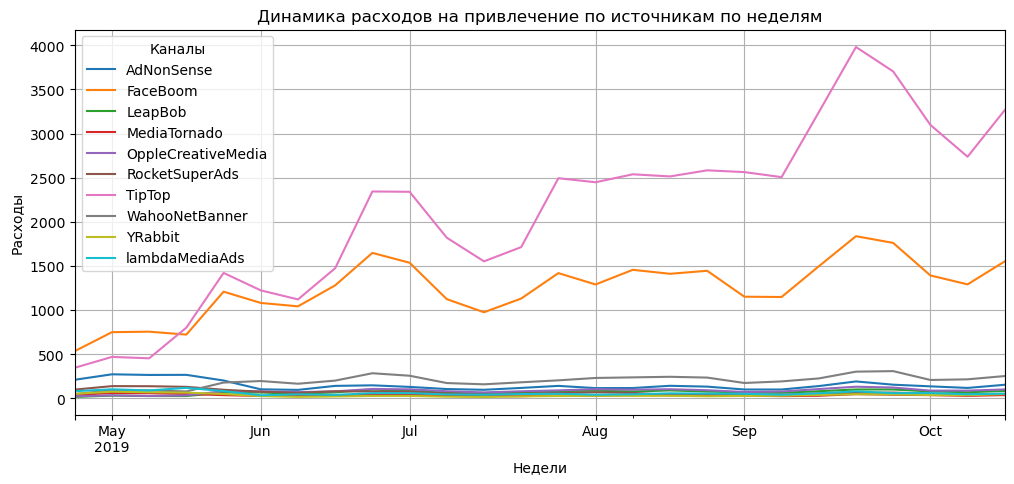

In [89]:
costs_plt = costs.pivot_table(
    index='week', 
    columns='channel', 
    values='costs',
    aggfunc='sum'
)

costs_plt.plot(figsize=(12,5), grid=True)
plt.xlabel('Недели')
plt.ylabel('Расходы')
plt.title('Динамика расходов на привлечение по источникам по неделям')
plt.legend(title='Каналы')
plt.show()

Расходы на TipTop и Faceboom растут, а на остальные каналы почти не меняются. В целом, это пока кажется нормальной ситуацией, т.к. у них хорошие показатели не только по количеству привлечений, но и по доле платящих. 

Теперь посмотрим то же самое по месяцам.

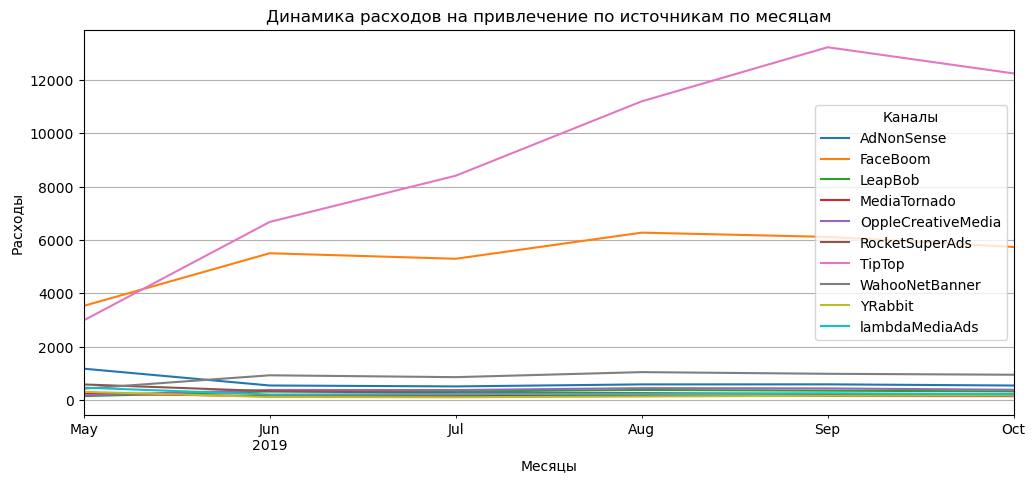

In [90]:
costs['month'] = costs['dt'].dt.to_period('M').dt.start_time
costs_plt = costs.pivot_table(
    index='month', 
    columns='channel', 
    values='costs',
    aggfunc='sum'
)

costs_plt.plot(figsize=(12,5), grid=True)
plt.xlabel('Месяцы')
plt.ylabel('Расходы')
plt.title('Динамика расходов на привлечение по источникам по месяцам')
plt.legend(title='Каналы')
plt.show()

Картина схожа с тем, что мы видели по неделям, но тут похоже, что по тратам на TipTop и FaceBoom снижение или стагнация.

### CAC

Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используем профили пользователей.

In [97]:
profiles.groupby('channel')['acquisition_cost'].mean()

channel
AdNonSense            1.008054
FaceBoom              1.113286
LeapBob               0.210172
MediaTornado          0.218717
OppleCreativeMedia    0.250000
RocketSuperAds        0.412095
TipTop                2.799003
WahooNetBanner        0.602245
YRabbit               0.218975
lambdaMediaAds        0.724802
organic               0.000000
Name: acquisition_cost, dtype: float64

Самая высокая средняя цена у TipTop(2.8). Она более, чем в 2 раза превосходит цену у второго места - FaceBoom(1.1). Следом идёт  AdNonSense(1) и lambdaMediaAds(0.7).

**Выводы.** Больше всего мы тратим на TipTop и FaceBoom. Также CAC для канала TipTop значетельно выше, чем у остальных. Пока сложно сказать, оправдано ли это, тк необходимо оценить ROI. Тем не менее, стоит отметить, что у этих каналось относительно большой процент платящих пользователей. На каналы AdNonSense и lambdaMediaAds мы тратим мало денег, но доля платящих у них высокая и CAC немного ниже, чем у FaceBoom.

## Оценка окупаемости рекламы

Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. Будет исходить из того, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Органических пользователей оценивать не будем, т.к. мы не тратим деньги на их привлечение.

Создадим отдельную переменную для таблицы пользователей без тех, кто пришёл сам.

In [114]:
profiles_acq = profiles.loc[(profiles['channel'] != 'organic')]

### Анализ графиков

Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.

Для этого сначала создадим необходимые переменные.

In [115]:
observation_date = datetime(2019,11,1).date()
analysis_horizon = 14
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_acq,
    orders,
    observation_date,
    analysis_horizon)

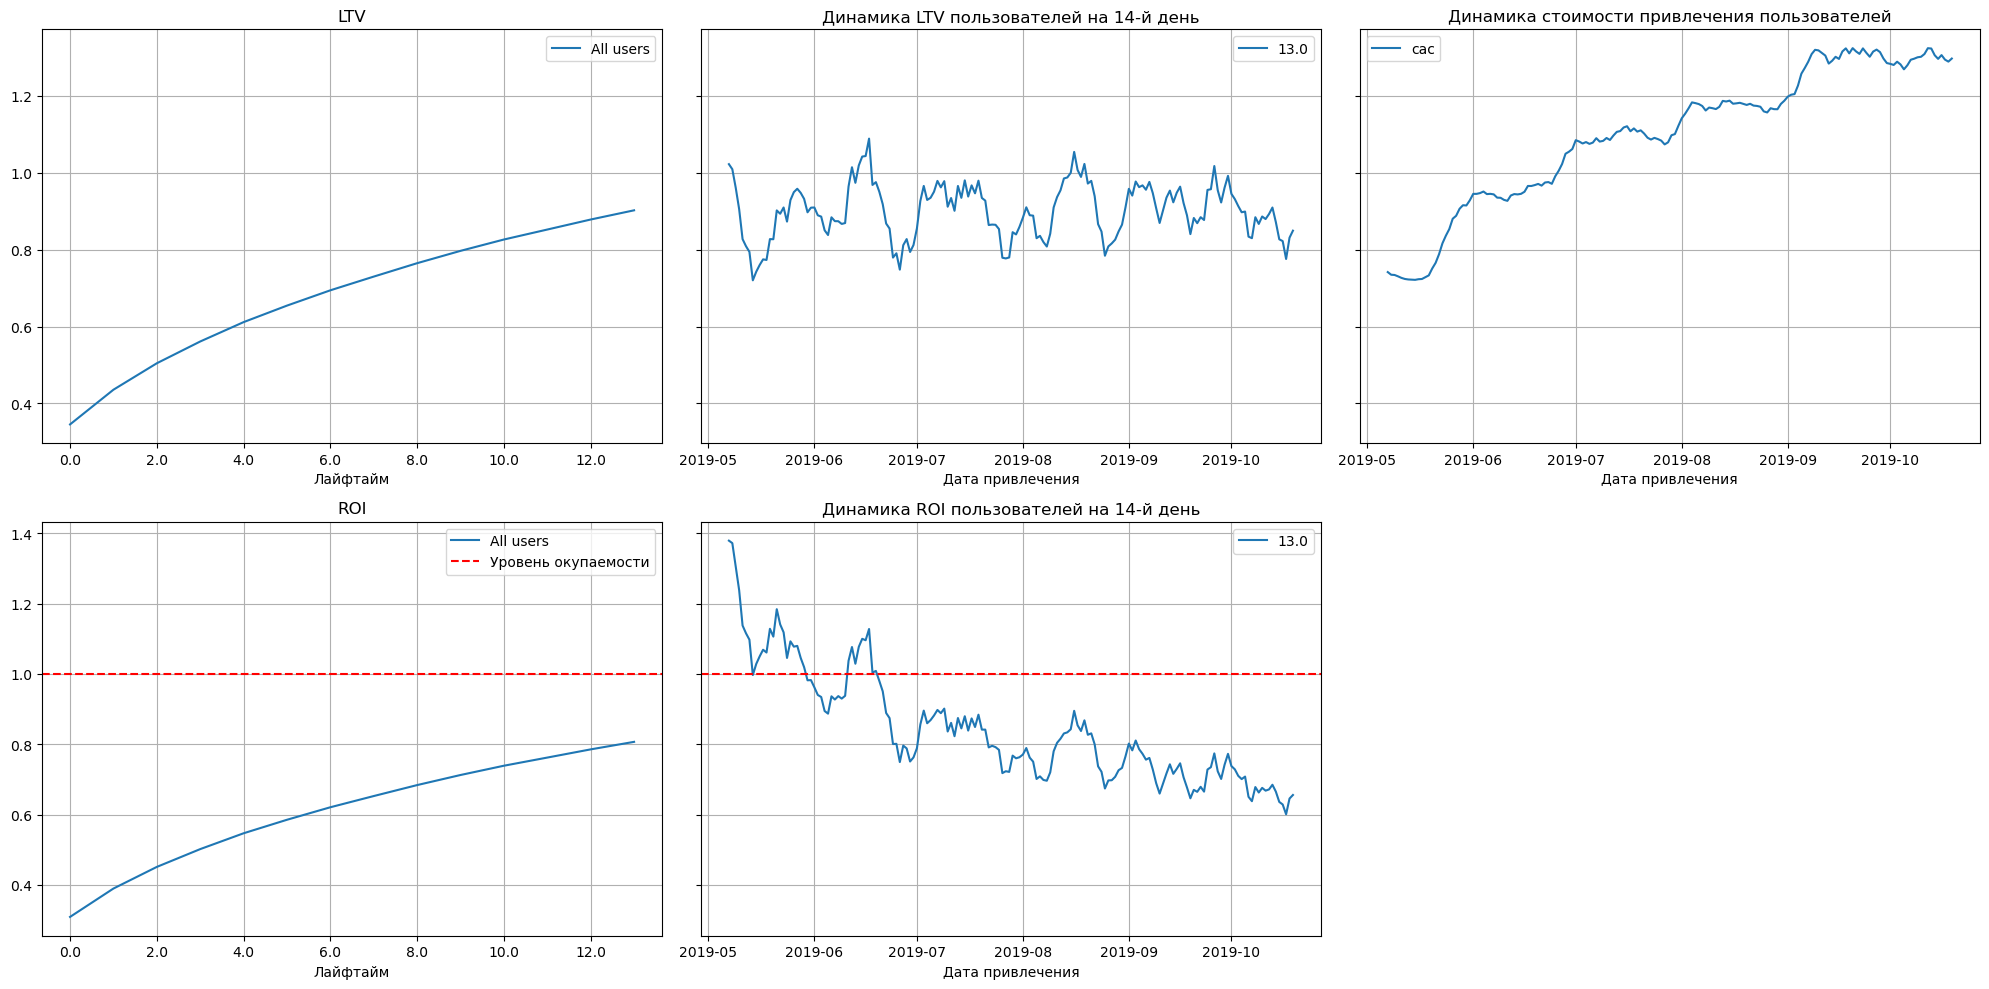

In [116]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, analysis_horizon, window=7)

Картина на графиках LTV и динамики LTV 14-го дня выглядит нормально. Ценность пользователей плавно прирастает в течение первых двух недель. На обозреваемом интервале динамики LTV, она опускается и поднимается, что является типичной картиной для многих компаний. Однако, при этом CAC активно растёт каждый месяц. Это отражается и на графике динамики ROI, с окупаемостью становится всё хуже. На уровне окупаемости пользователей к 14 дню компания была только в самом начале периода, а сейчас коэффициент равен 0.6.

Что-то явно не в порядке и это нужно исправлять.

### Конверсия и удержание

Построим графики конверсии и динамики её измений.

#### Общая конверсия

Сначала получим данные по конверсии.

In [117]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles_acq,
    orders,
    observation_date,
    analysis_horizon)

Теперь построим графики.

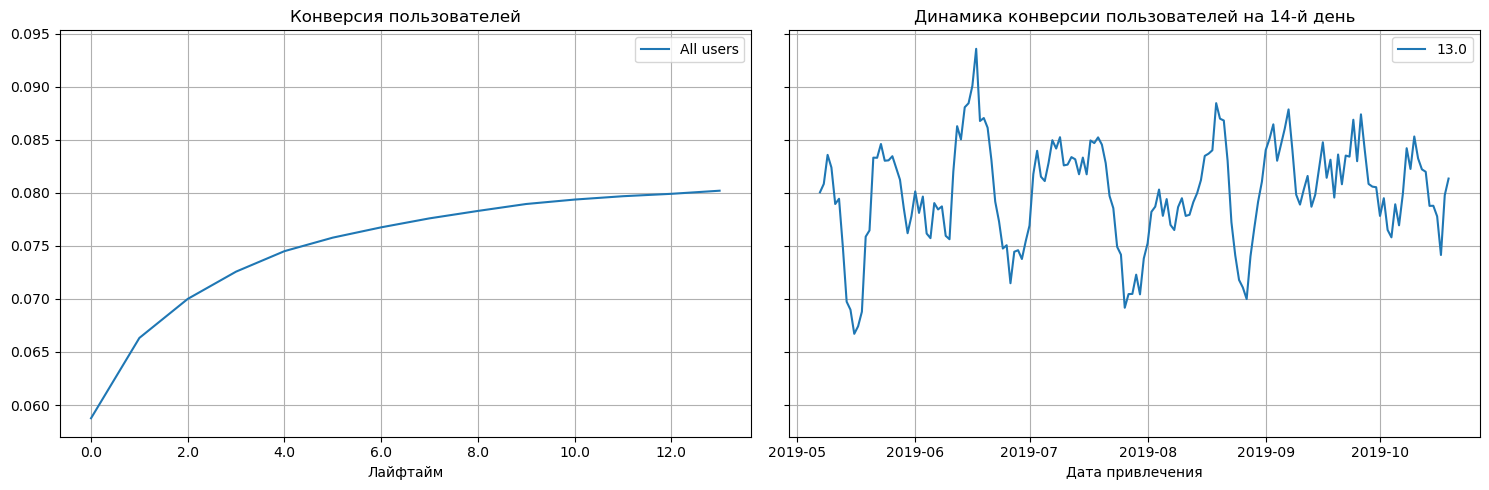

In [118]:
plot_conversion(conversion, conversion_history, analysis_horizon, window=7)

В среднем за обозреваемый период конверсия достигает 8% к 14-му дню. По историческим данным конверсия на 14-й день колебалась от 6.7% до 9.3%. С динамикой конверсии явных проблем нет, так что скорее всего причина не в ней. Тем не менее давайте посмотрим эту метрику в разбивке по разным параметрам.

#### Конверсия по устройствам

In [131]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles_acq,
    orders,
    observation_date,
    analysis_horizon,
    dimensions=['device'])

Увеличим окно сглаживания до 14, чтобы улучшить читаемость.

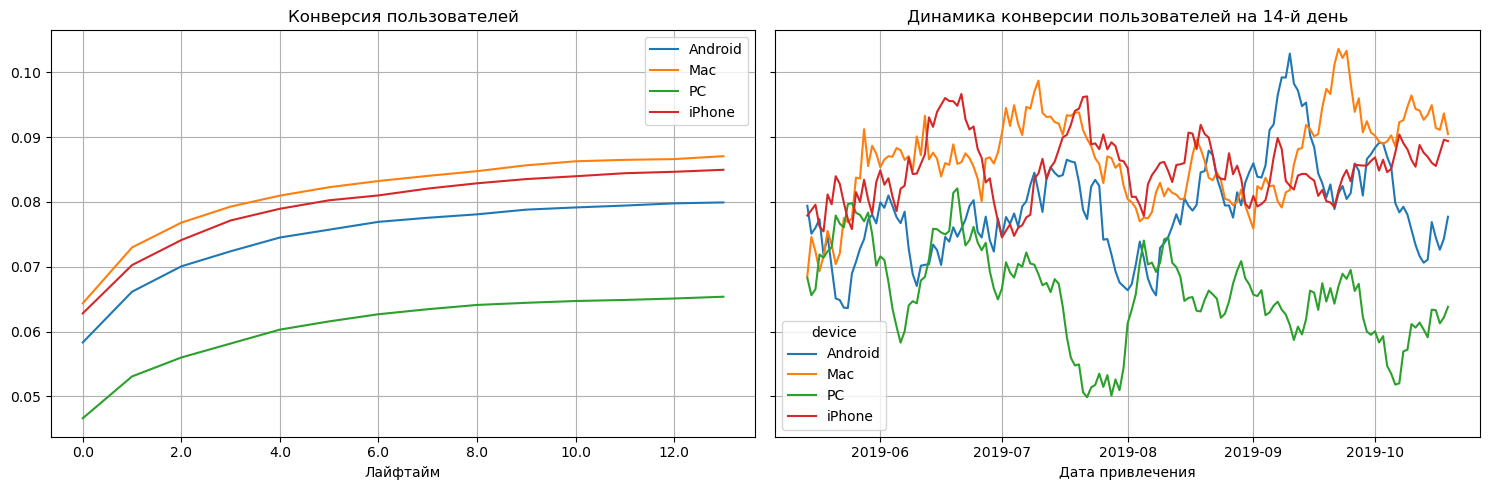

In [133]:
plot_conversion(conversion, conversion_history, analysis_horizon, window=14)

Хуже всего конвертируются к 14 дню пользователи пк (6,5%). Все остальные примерно на одном уровне от 8% до 9%.

#### Конверсия по странам

In [134]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles_acq,
    orders,
    observation_date,
    analysis_horizon,
    dimensions=['region'])

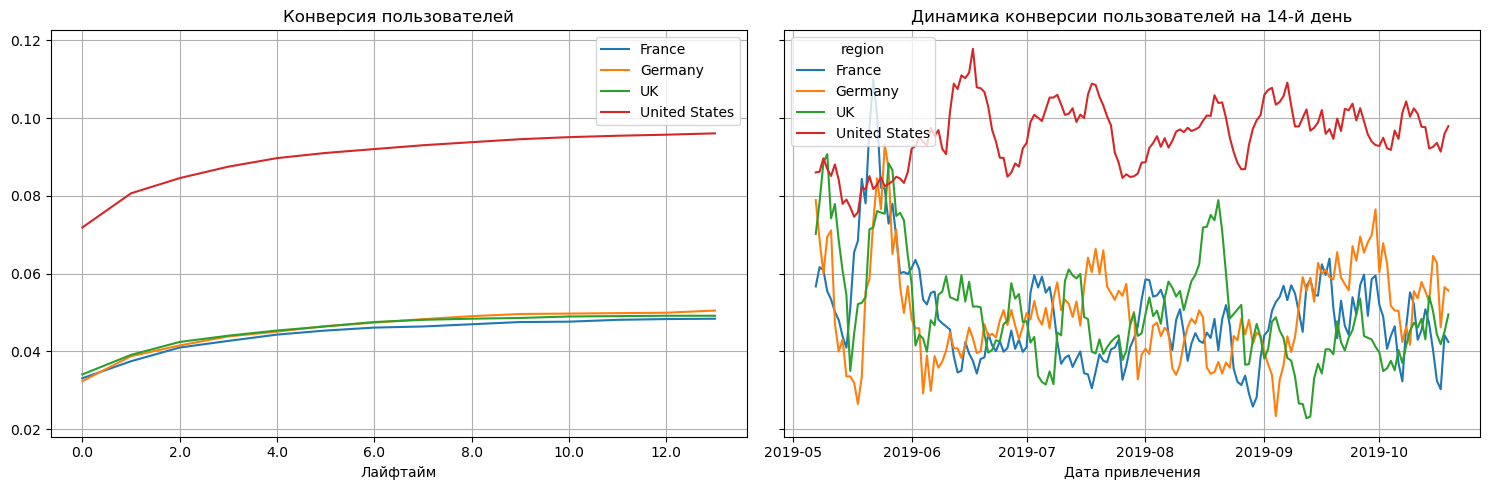

In [135]:
plot_conversion(conversion, conversion_history, analysis_horizon, window=7)

По странам видим картину, что США сильно всех обогнали (почти 10%). Остальные на уровне 5%. На динамике интересная картина в начале периода: начали с высоких значений, сразу наступил резкий сильный спад и потом ещё более сильный резкий подъём. Возможно, это было удачная кампания.

#### Конверсия по каналам

In [136]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles_acq,
    orders,
    observation_date,
    analysis_horizon,
    dimensions=['channel'])

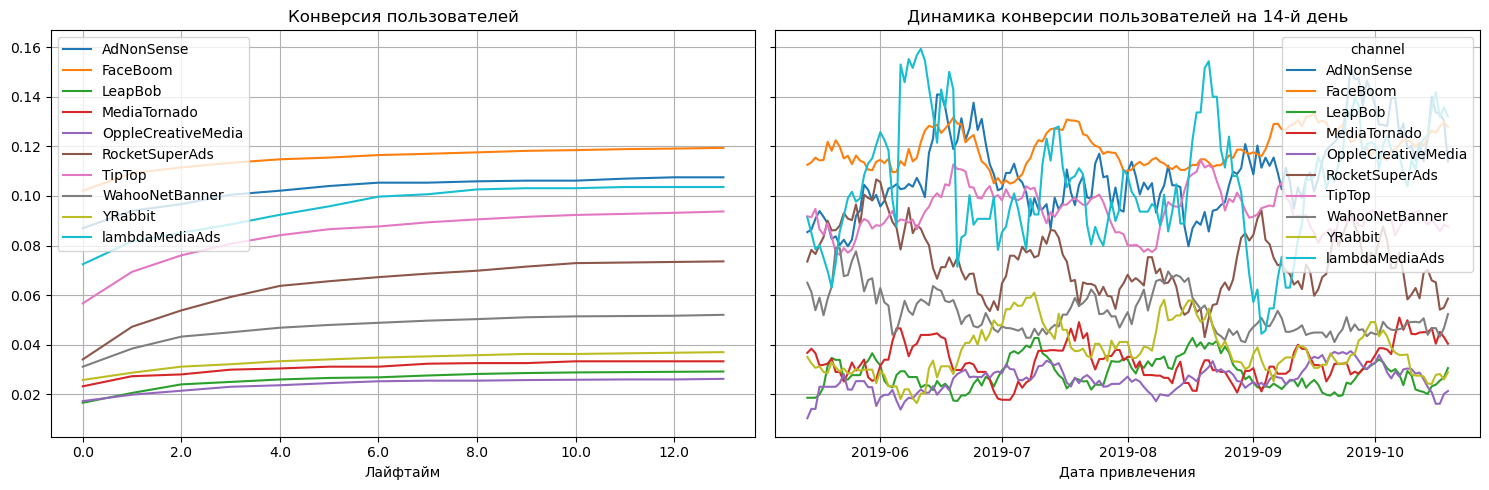

In [139]:
plot_conversion(conversion, conversion_history, analysis_horizon, window=14)

По общей статистике конверсии на первом месте FaceBoom(12%), затем AdNonSense(11%), потом lambdaMediaAds(10.5%) и TipTop(9.5%). Можно ещё выделить RocketSurepAds и WahooNetBanner, имеющих средние результаты. Остальные расположились кучно внизу. По динамике картина в целом нормальная. Можно выделить, что у lamdaMediaAds постоянные резкие подъёмы и спады, причём на подъёмах они сильно обгоняют остальные каналы (до 16% конверсии).

### Удержание

#### Общее удержание

In [141]:
retention_raw, retention, retention_history = get_retention(
    profiles_acq,
    visits,
    observation_date,
    analysis_horizon)

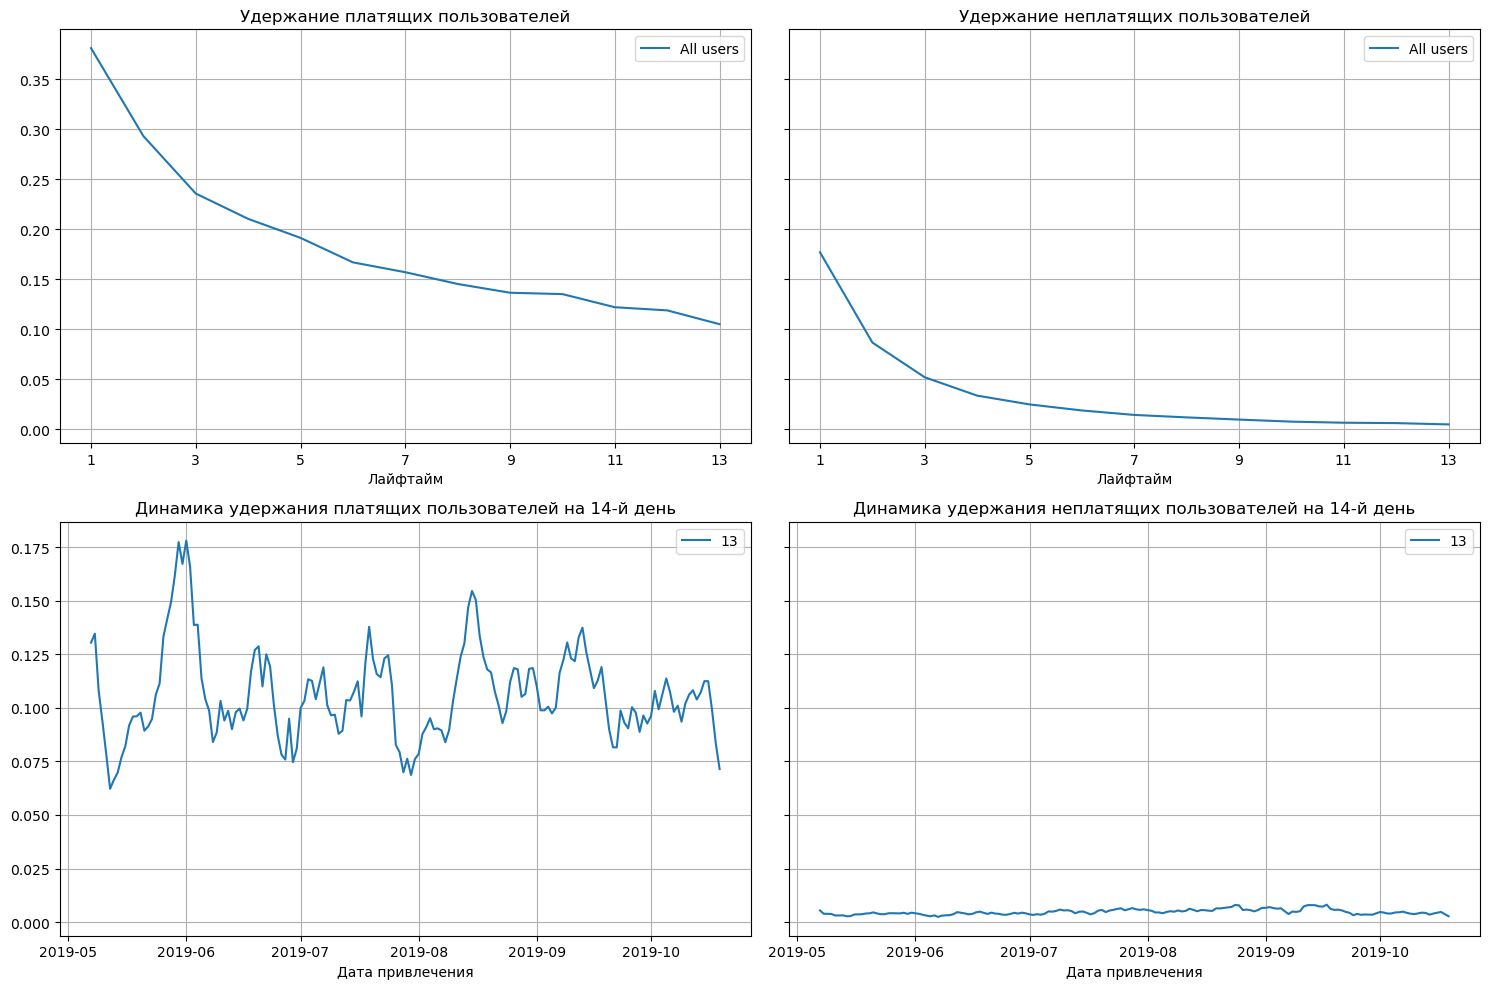

In [142]:
plot_retention(retention, retention_history, analysis_horizon, window=7)

Удержание выглядит достаточно низким, но возможно это специфика данного рынка. 

Среди платящих пользователей удержание 14-го дня составляет 10%. Среди неплатящих примерно 1%. На графике динамики удержание 14-го дня для платящих колебалось от примерно 7% до 17%. Для неплатящих от 0.5% до 1.5%.

#### Удержание по устройствам

In [143]:
retention_raw, retention, retention_history = get_retention(
    profiles_acq,
    visits,
    observation_date,
    analysis_horizon,
    dimensions=['device'])

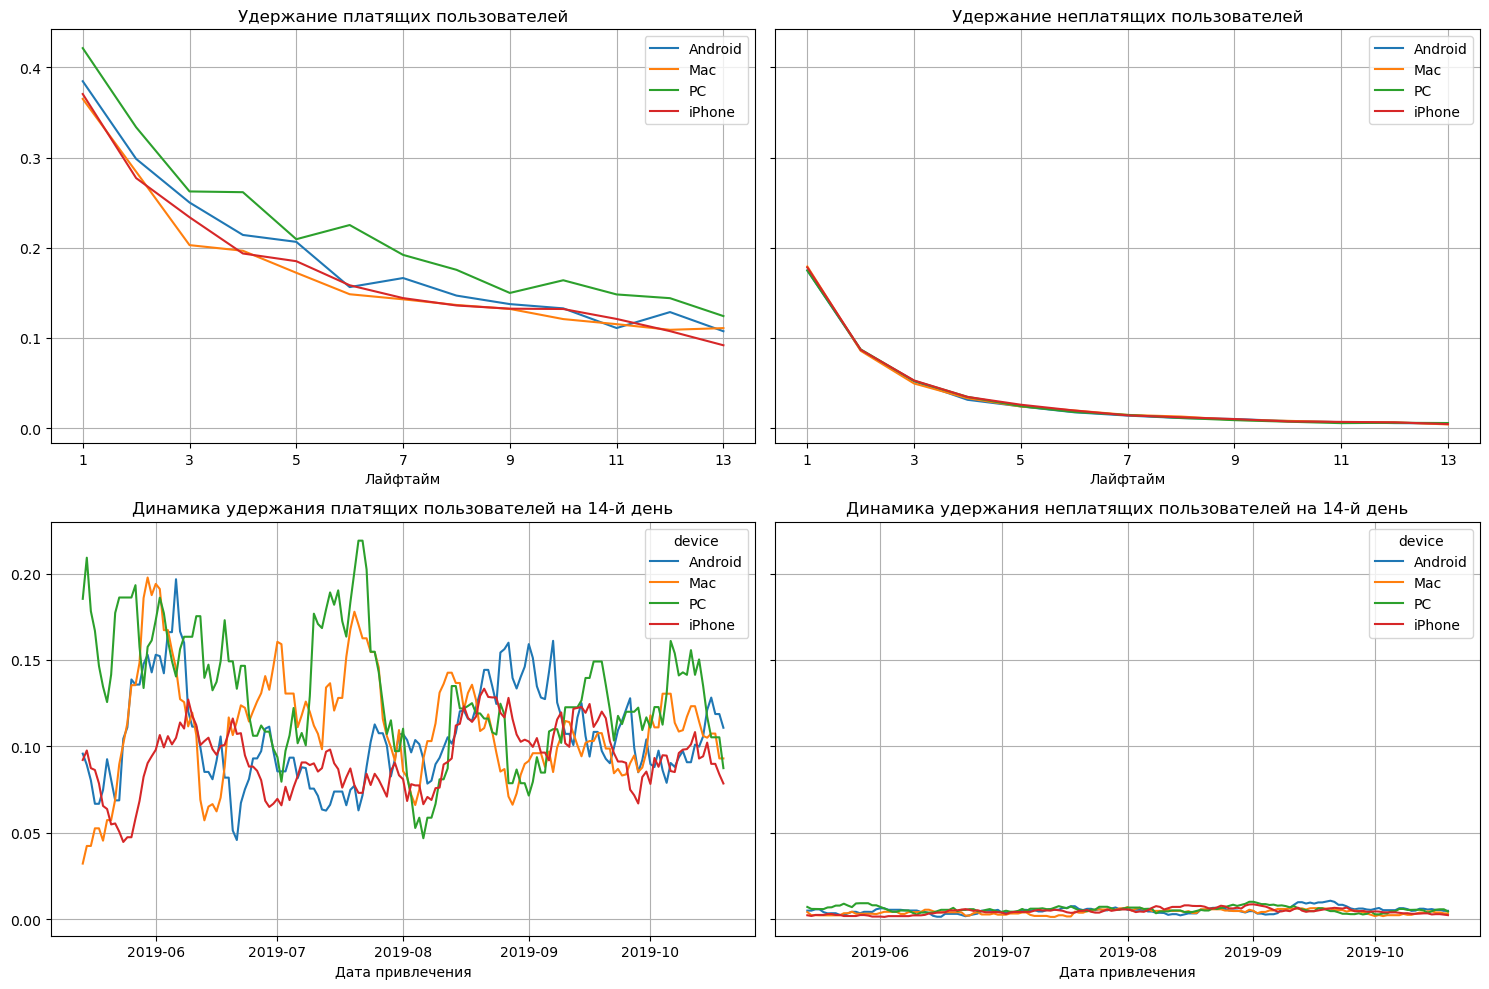

In [145]:
plot_retention(retention, retention_history, analysis_horizon, window=14)

В разбивке по устройствам картина схожая. Из интересного можно выделить, что среди платящих пользователей картина противоположна конверсии. Лучше всех явно удерживаются пользователи пк, а андроид обгоняет Iphone и Mac. При  это Mac поднимался на второе место в летний сезон.

#### Удержание по странам

In [146]:
retention_raw, retention, retention_history = get_retention(
    profiles_acq,
    visits,
    observation_date,
    analysis_horizon,
    dimensions=['region'])

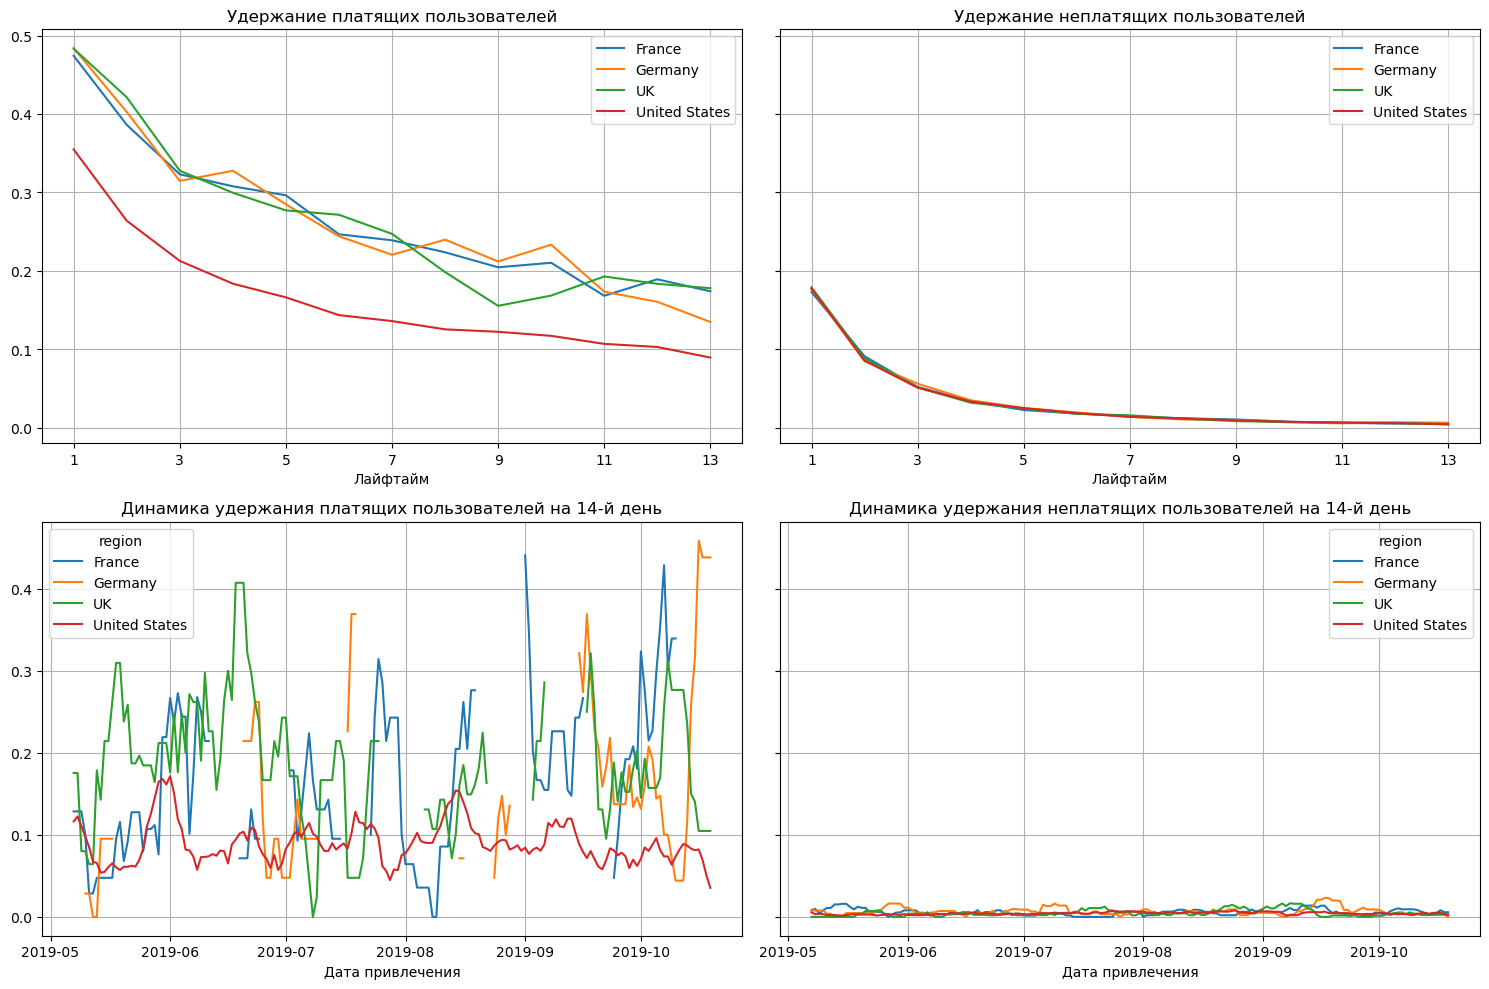

In [149]:
plot_retention(retention, retention_history, analysis_horizon, window=7)

Картина снова противоположна конверсии. США явный аутсайдер (9%) среди платящих, а остальные идут очень близко. У Франции и Великобритании к 14 дню 17.5%, а у Германии 14%. График динамики по платящим для США довольной стабильный, а для остальный рваный (есть пробелы в данных), с постоянными скачками вниз и вверх. Это вероятно стоит передать отделу маркетинга.

#### Удержание по каналам

In [150]:
retention_raw, retention, retention_history = get_retention(
    profiles_acq,
    visits,
    observation_date,
    analysis_horizon,
    dimensions=['channel'])

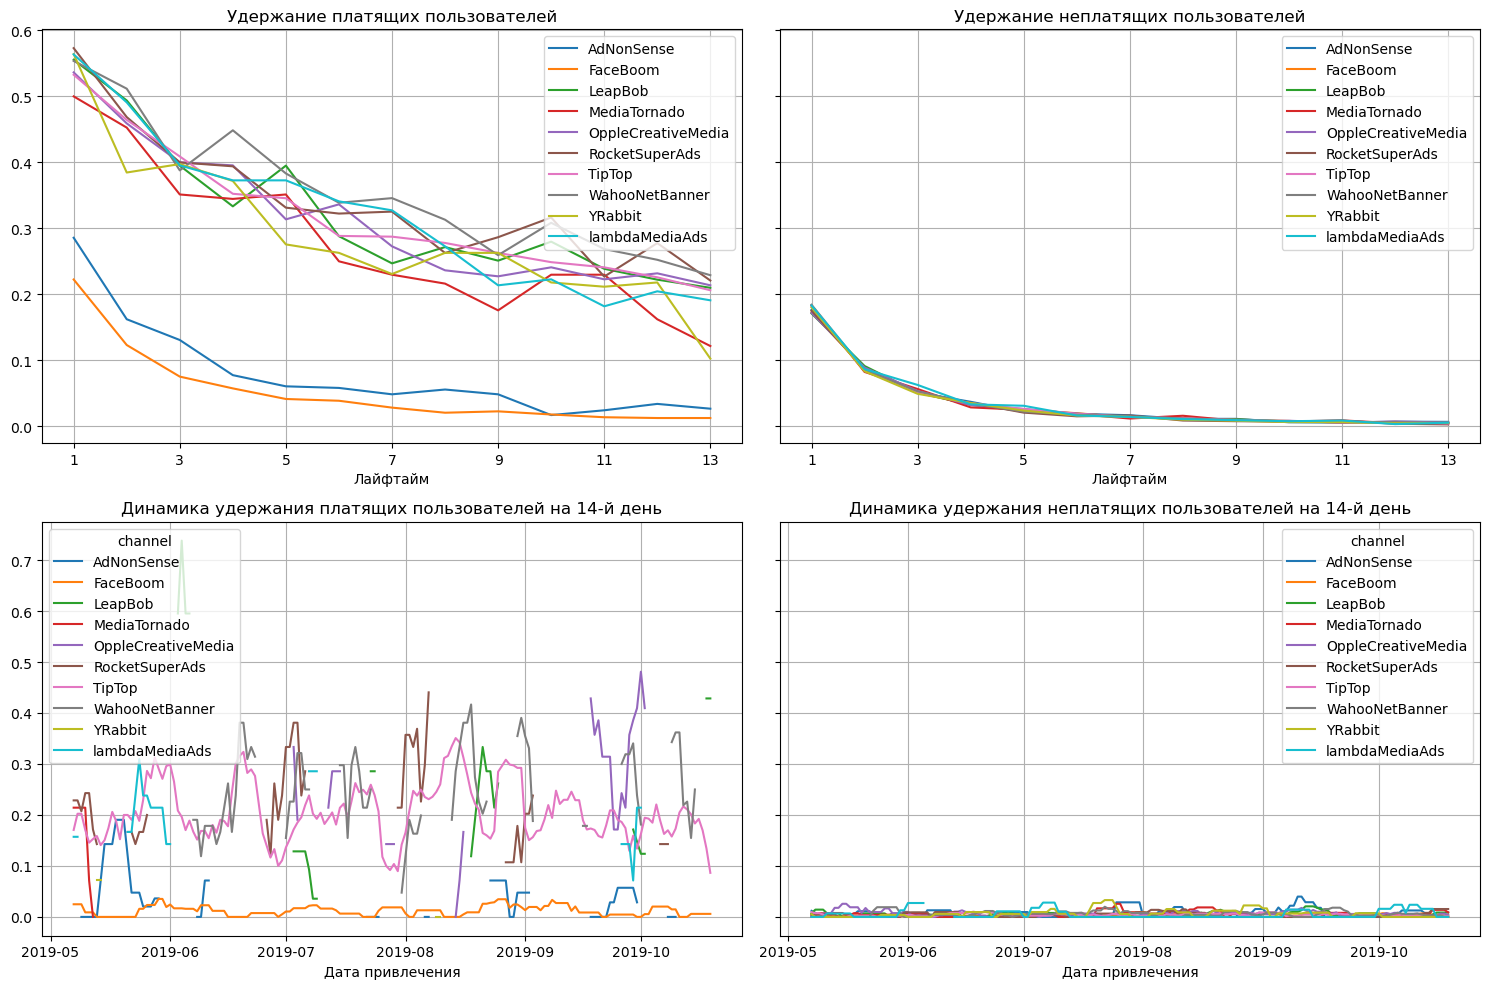

In [153]:
plot_retention(retention, retention_history, analysis_horizon, window=7)

Картина по платящим снова частично противоположна конверсии. По общим данным явные аутсайдеры FaceBoom(1.5%) и AdNonSense (3%). Остальные идут кучко, но в конце резкое падение у YRabbit(10%) и MediaTornado (12%). Остальные на уровне 20%. До динамике картина рваная для всех, кроме TipTop и FaceBoom.

### Окупаемость рекламы

#### Окупаемость по устройствам

Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

In [155]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_acq,
    orders,
    observation_date,
    analysis_horizon,
    dimensions=['device'])

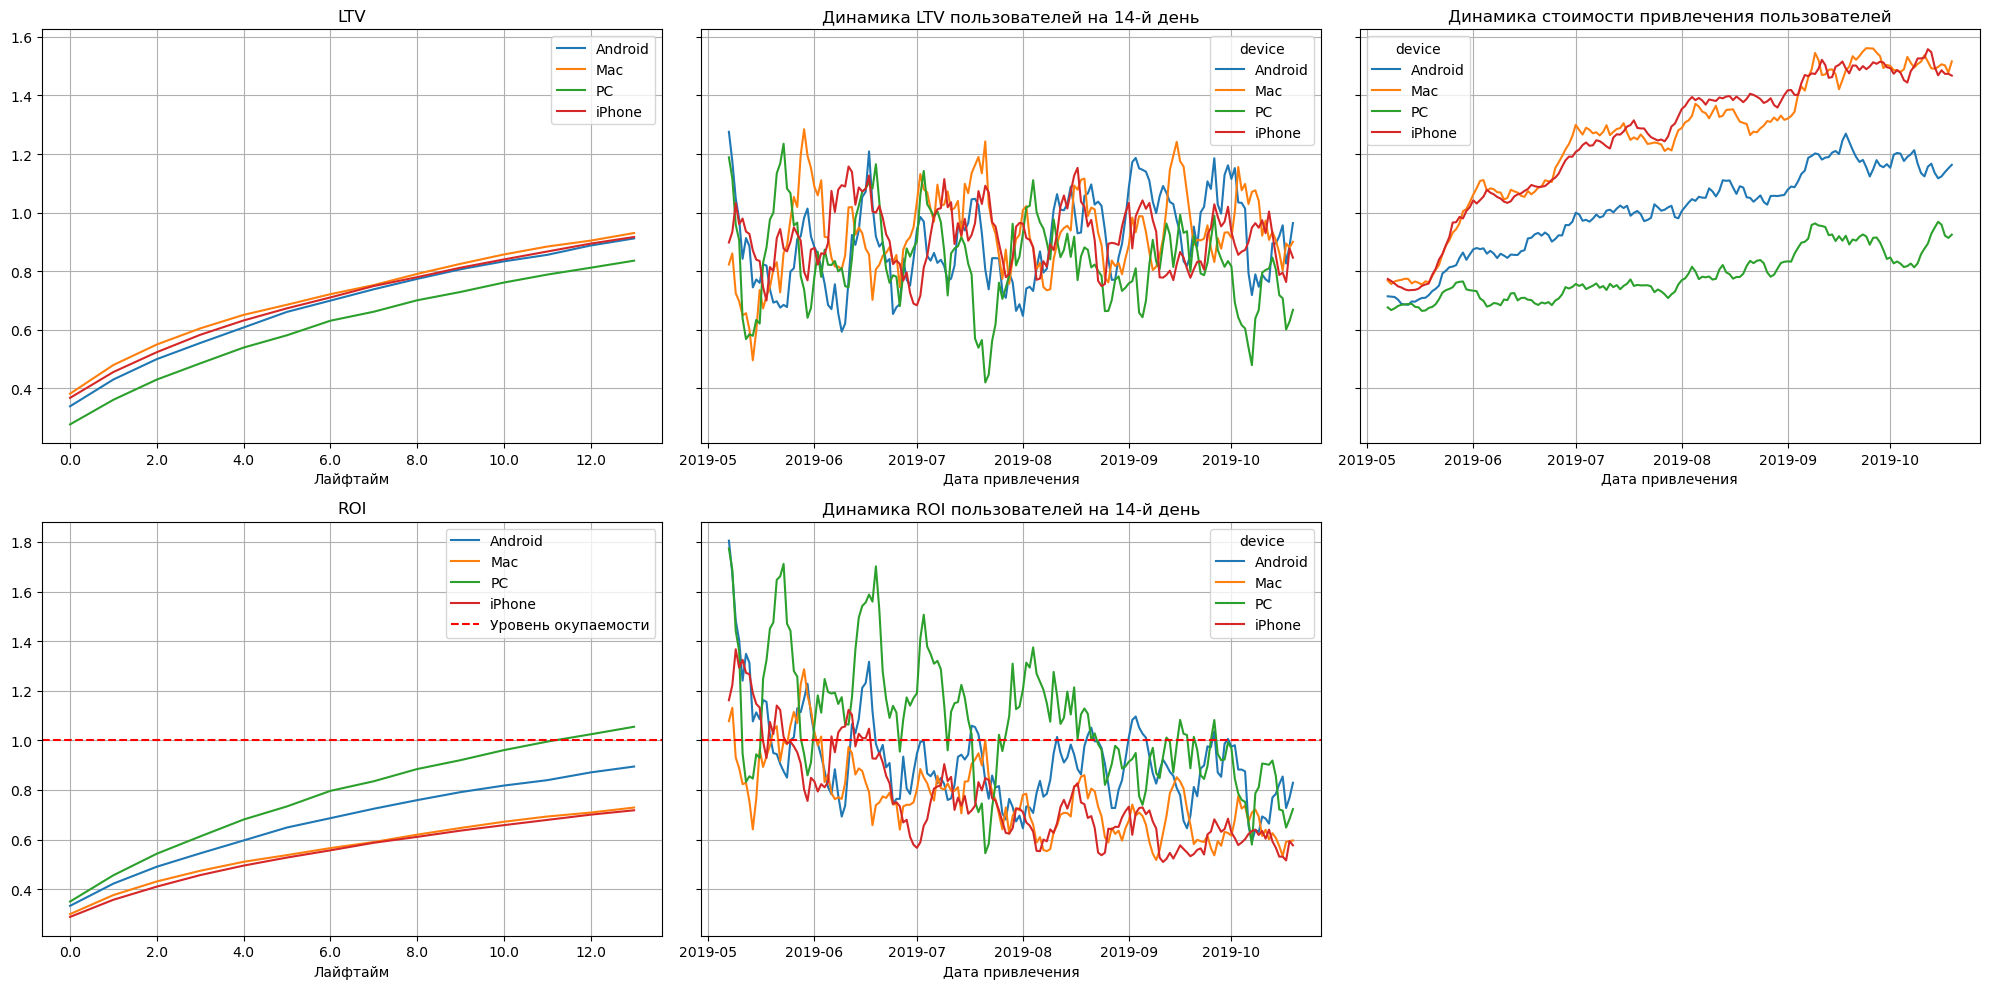

In [156]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, analysis_horizon, window=7)

По LTV проседает ПК (чуть больше 0.8), остальные идут кучно (0.9). По CAC самые дешёвые ПК, затем Android. Mac и Iphone обходятся дорого.

По ROI к 14 дню окупаются только пользователи ПК, Android близки к этому (0.9), а Iphone и Mac вероятно не окупаются вообще (всего 0.7). По динамике мы видим, что ПК периодами отбивались на 200% и Android окупались лучше и выходили в плюс. А вот Iphone и Mac приносили прибыль только в самом начале.

#### Окупаемость по странам

In [157]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_acq,
    orders,
    observation_date,
    analysis_horizon,
    dimensions=['region'])

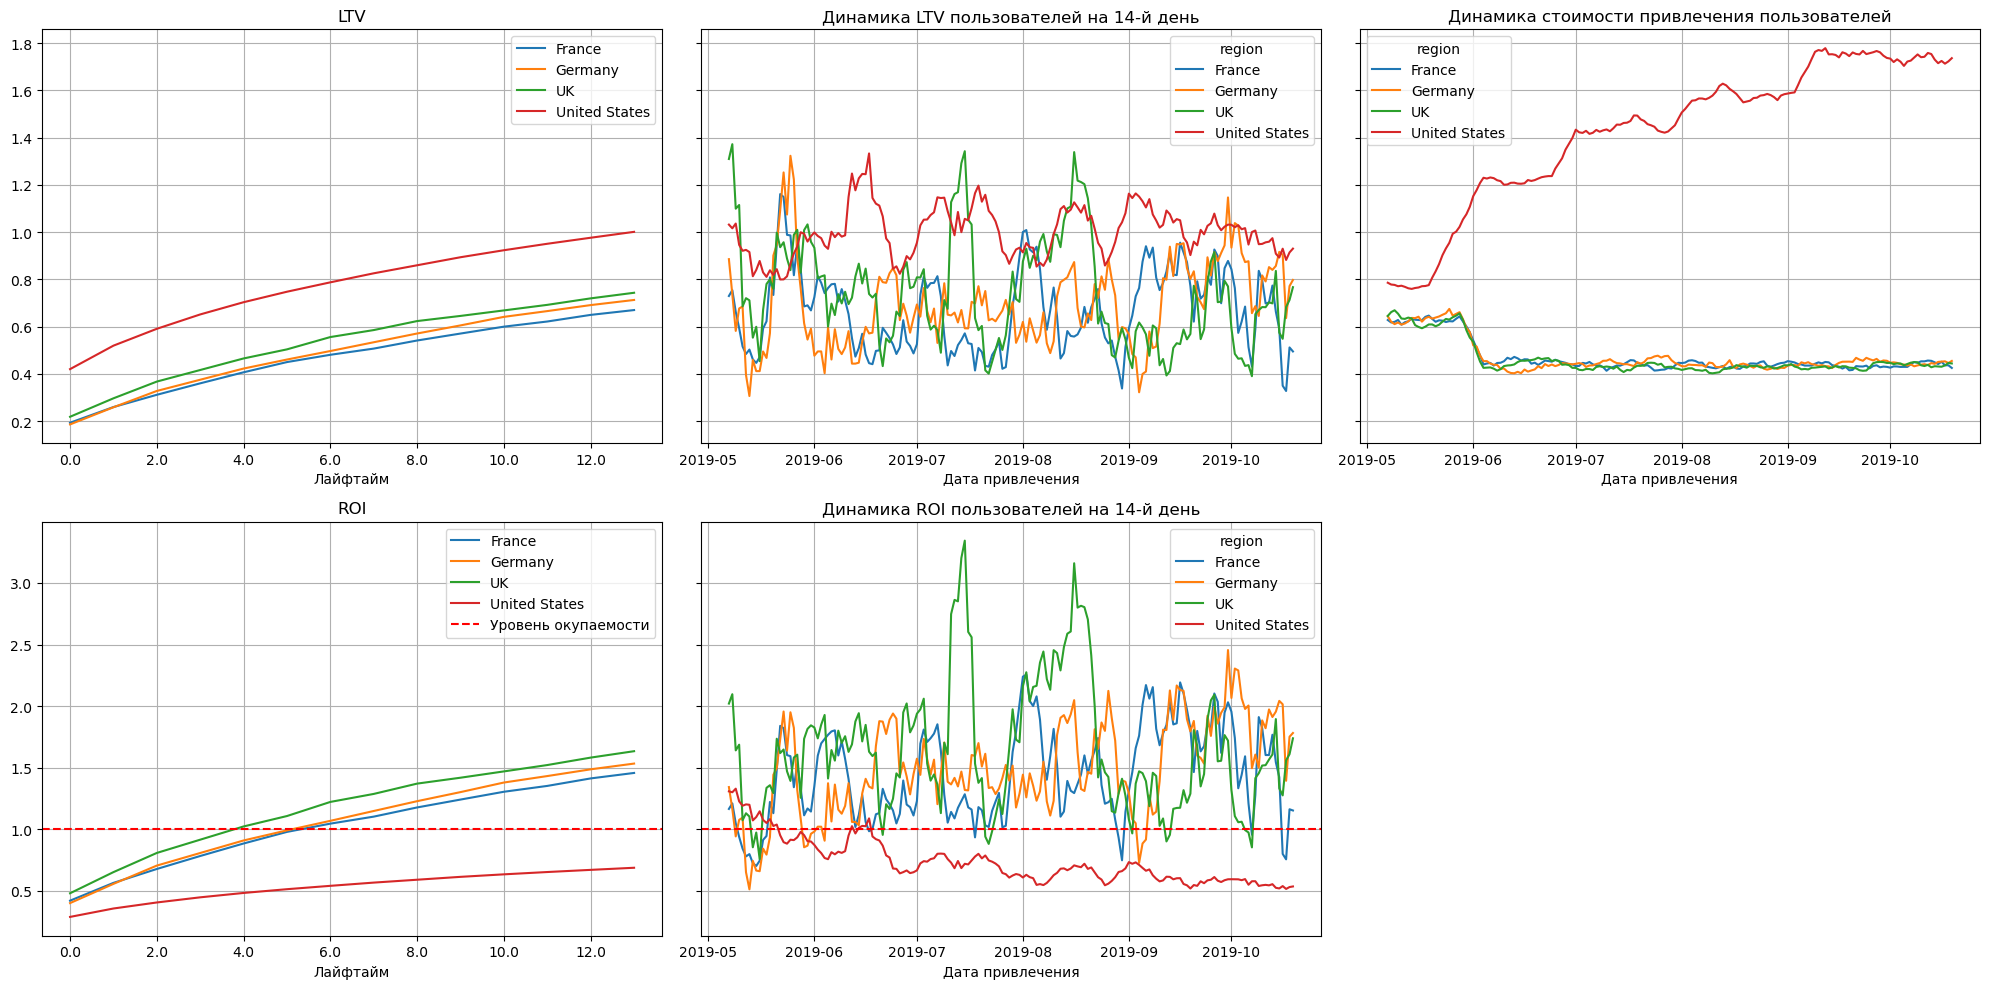

In [158]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, analysis_horizon, window=7)

По LTV 14-го дня мы видим, что в лидерах США - 1, а остальные на уровне 0.65 - 0.75. По динамике LTV у Великобритании много пиков до 1.4. 

На графике CAC мы видим, что начинают все с примерно одинаковых значений, но потом почти сразу стоимость привлечения для США улетает в небеса - 1.8. А вот для остальных стран наоборот падает с 0.6 до 0.4. 

По ROI получается ожидаемая картина. Пользователи из США к 14 дню явно не окупаются - 0.7. А вот остальные показывают отличные 1.5 и выше.

#### Окупаемость по каналам

In [159]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_acq,
    orders,
    observation_date,
    analysis_horizon,
    dimensions=['channel'])

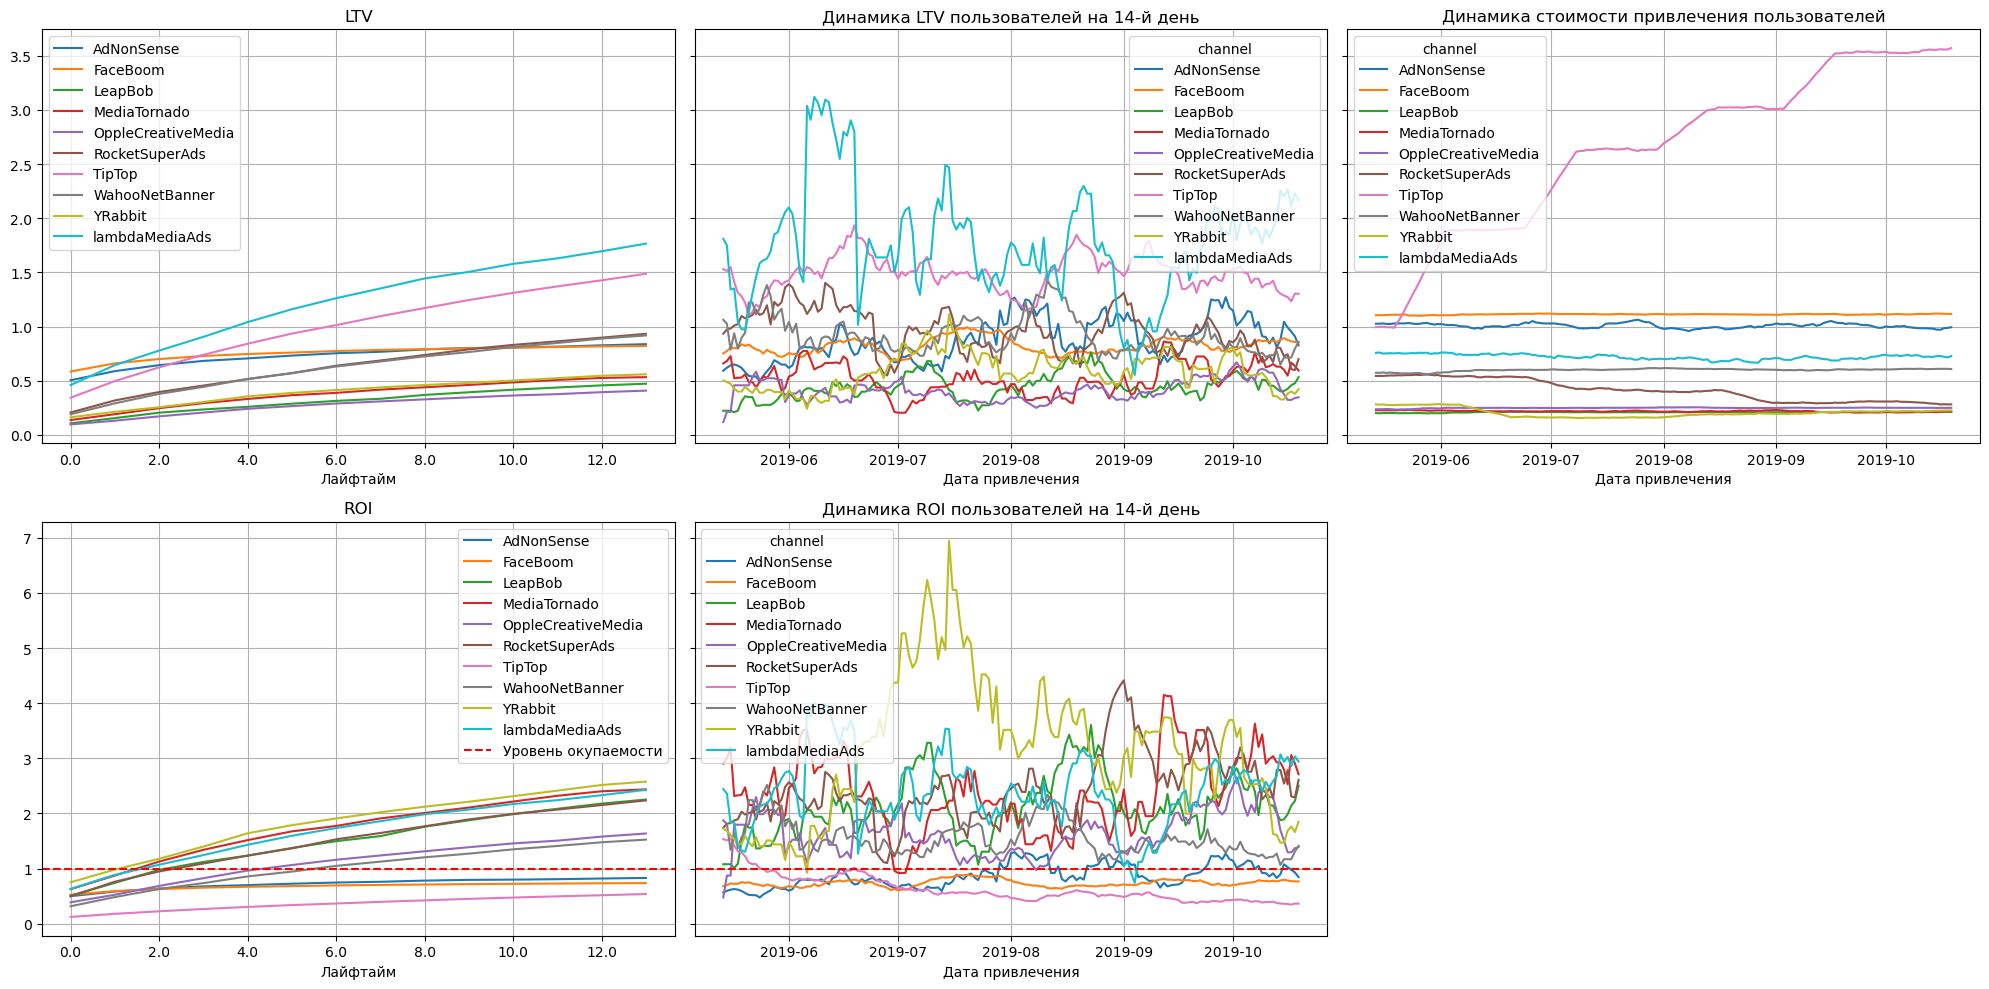

In [163]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, analysis_horizon, window=14)

По LTV в явных лидерах lambdaMediaAds и TipTop. На графике динамики у lambdaMediaAds очень резкие колебания. 

На графике CAC мы видим, что в небо улетает цена привлечения по каналу TipTop, а остальные идут ровно. Можно предположить, что это основной или единственный канал привлечения для США.

По графику ROI мы видим, что не окупаются каналы TipTop, FaceBoom и AdNonSense. Неплохо окупаются WahooNetBanner и OppleCreativeMedia - около 1.5. И очень хорошие показатели у остальных - от 2.2 до 2.7. На графике динамики мы видим впечатляющий пик у YRabbit, который помог ему занять первое место в общей статистике.

### Ответы на вопросы

#### Окупается ли реклама, направленная на привлечение пользователей в целом?

Нет, не окупается. К 14-му дню показатель ROI 0.8, то есть возвращаются 80% инвестий. При этом динамика отрицательная, так что дела идут всё хуже и хуже.

#### Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?

Среди устройств это в первую очередь Iphone и Mac - 70% к 14-му дню. У Android ситуация лучше - 90%.

Среди стран проблема в США. Их окупаемость 70%, против 150% для остальных стран.

Среди каналов явно не окупается TipTop - 50%, а также проблемы у FaceBoom и AdNonSense - 80-90%.

#### Чем могут быть вызваны проблемы окупаемости?

1) У США, пользователей Mac, Iphone и Android (в меньшей степени) и каналов FaceBoom и AdNonSence очень высокая конверсия. Но при этом у них всех худшие показатели по удержанию. Возможно большой процент этих пользователей быстро совершают покупку, но после этого также быстро перестают пользоваться приложением. В итоге это приводит к тому, что ROI для них всех ниже уровня окупаемости.

2) Средняя цена на привлечение одного пользователя из США и через канал TipTop активно растёт. За полгода для США это значение выросло более чем в 2 раза (с 0.8 до 1.7), а для канала TipTop в 3.5 раза (с 1 до 3.5). Вероятно, этот канал один из основных для пользователей США, но он невыгоден. У канала TipTop худший показатель ROI - около 50%. 

### Дополнительный анализ

Перед тем, как переходить к выводам, посмотрим ещё нескольк вещей.

Сналача посмотрим, как изменится общее распределение пользователей по странам, если мы исключим органических пользователей.

In [167]:
profiles.groupby('region').agg({'user_id':'nunique'}).sort_values('user_id', ascending=False)

user_id
region                
United States   100002
UK               17575
France           17450
Germany          14981

In [166]:
profiles_acq.groupby('region').agg({'user_id':'nunique'}).sort_values('user_id', ascending=False)

user_id
region                
United States    61829
UK               11154
France           11058
Germany           9528

Изменения достаточно симметричны.

Теперь посмотрим, какие каналы привлечения и устройства характерны для США.

In [177]:
profiles_usa = profiles_acq.loc[(profiles['region'] == 'United States')]

In [178]:
profiles_usa.groupby('channel').agg({'user_id':'nunique'})

user_id
channel                
FaceBoom          29144
MediaTornado       4364
RocketSuperAds     4448
TipTop            19561
YRabbit            4312

Получается, что у каналов есть специализация по регионам. Эти 5 каналов единственные, кто работает с США и, при этом, сами они работают только с США.

In [179]:
profiles_usa.groupby('device').agg({'user_id':'nunique'})

user_id
device          
Android    12436
Mac        15424
PC          6421
iPhone     27548

Жители США используют Айфоны и Маки чаще, чем представители трёх других стран.

Проверим LTV, CAC и ROI по пользователям из США с разбивкой по устройствам.

In [180]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_usa,
    orders,
    observation_date,
    analysis_horizon,
    dimensions=['device'])

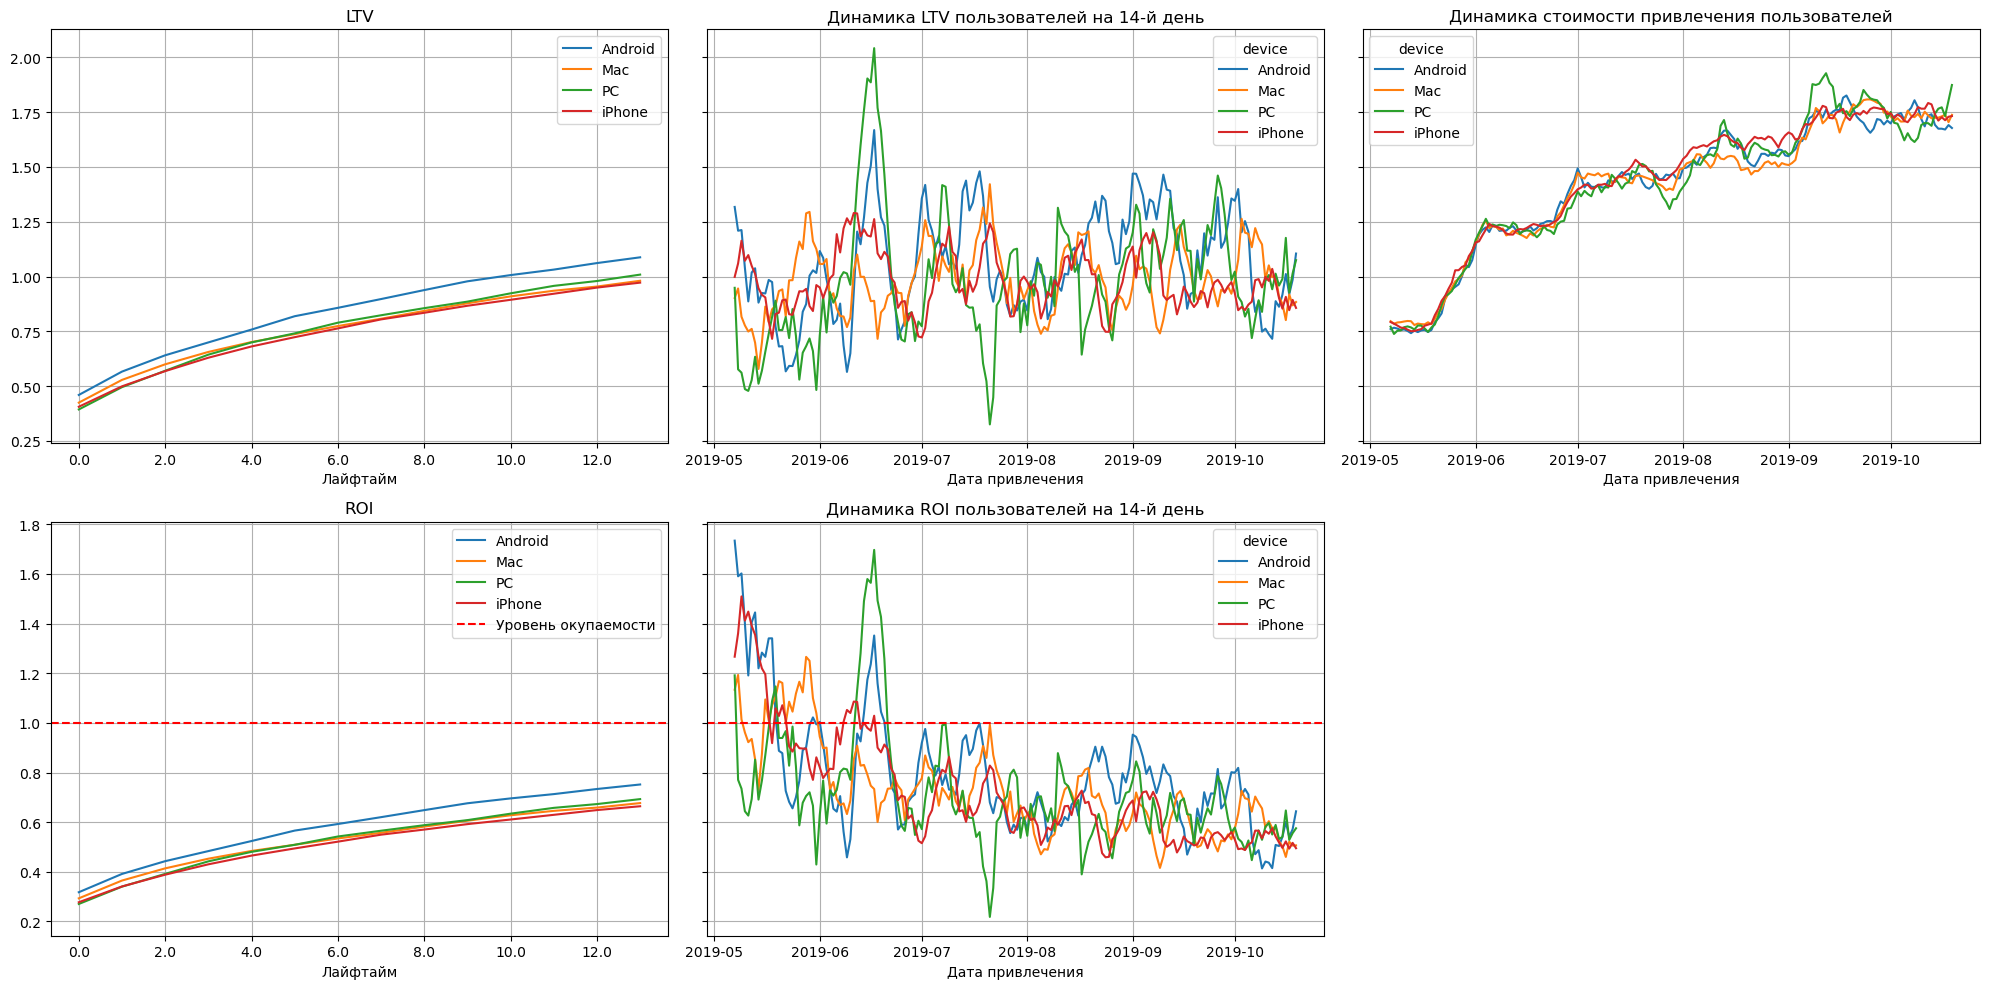

In [181]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, analysis_horizon, window=7)

Получается, что пользователи из США оказываются примерно одинаково невыгодными вне зависимости от устройств.

А теперь с разбивкой по каналам.

In [182]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_usa,
    orders,
    observation_date,
    analysis_horizon,
    dimensions=['channel'])

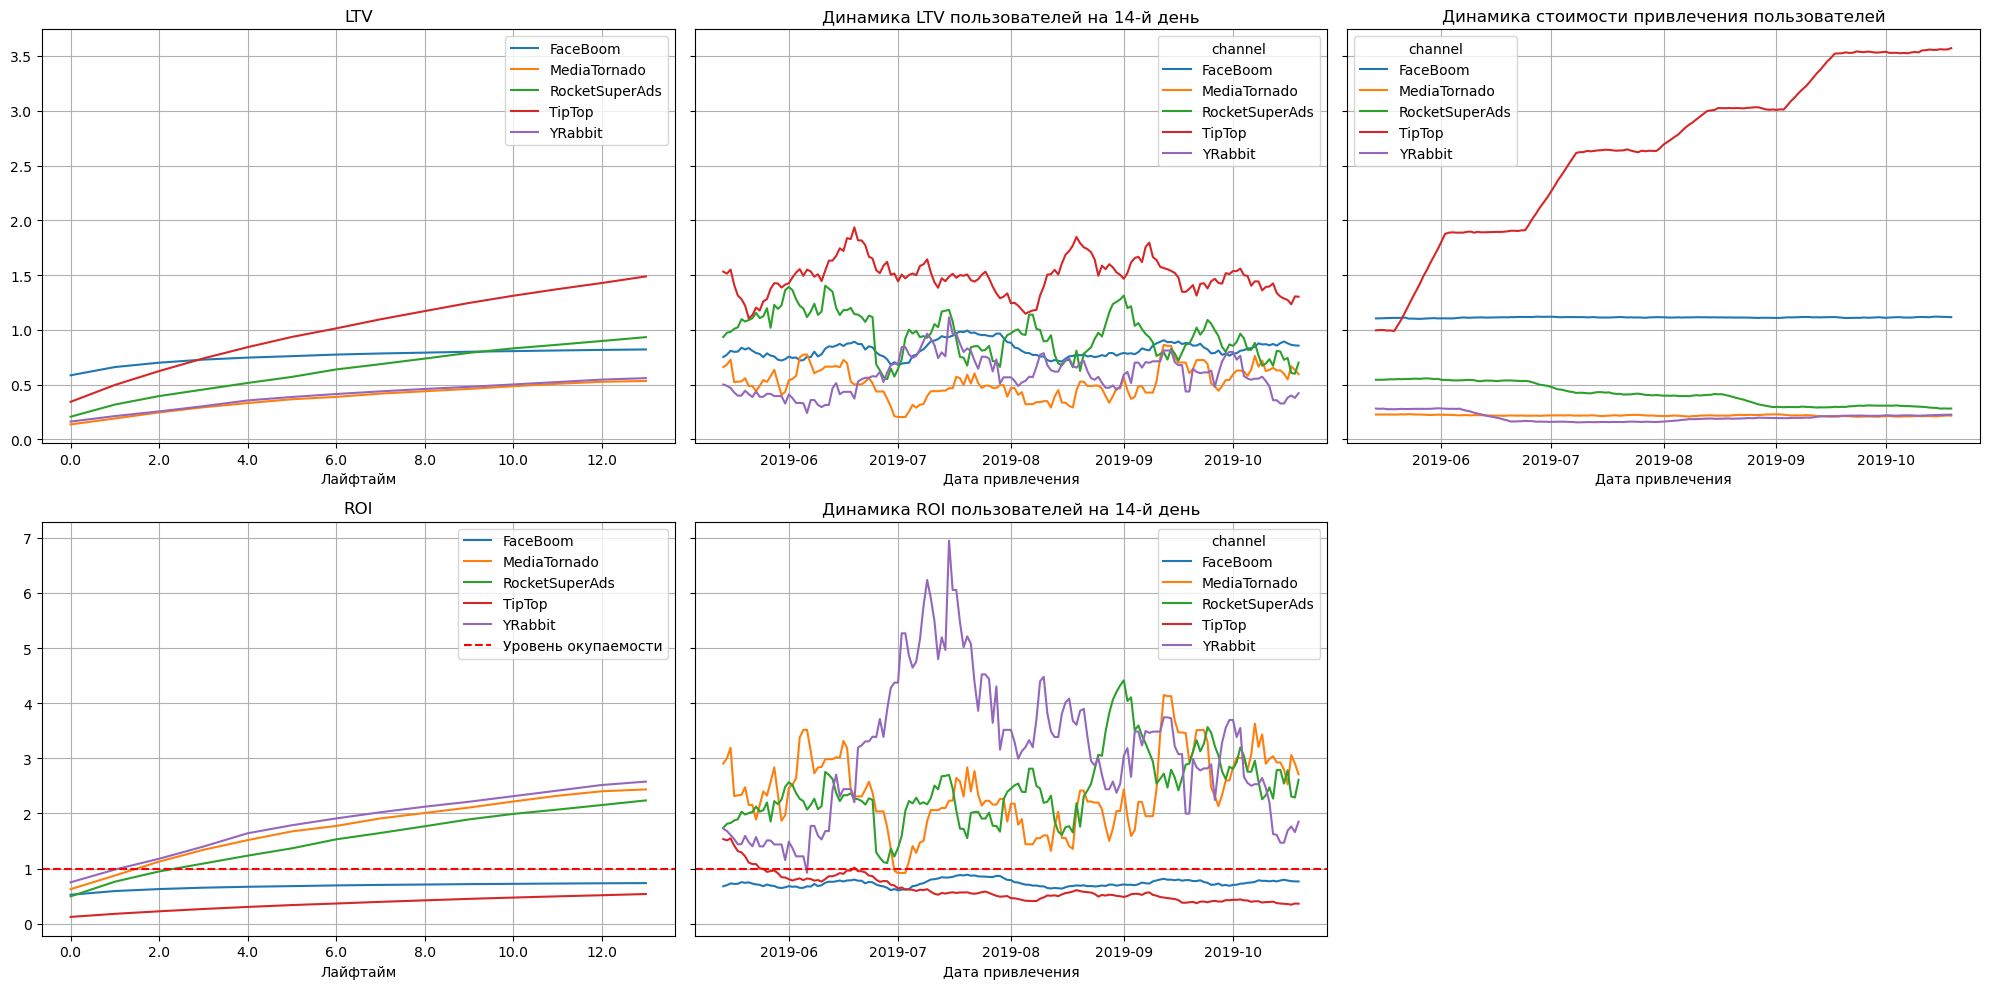

In [183]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, analysis_horizon, window=14)

А вот это уже интересно. Два наиболее представленных канала не окупаются. Зато 3 других (YRabbit, MediaTornado и RocketSuperAds) показывают отличные результты (220%-270%).

Проверим последний неокупающийся канал - AdNonSense.

In [184]:
profiles_ans = profiles_acq.loc[(profiles['channel'] == 'AdNonSense')]

In [191]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_ans,
    orders,
    observation_date,
    analysis_horizon,
    dimensions=['region'])

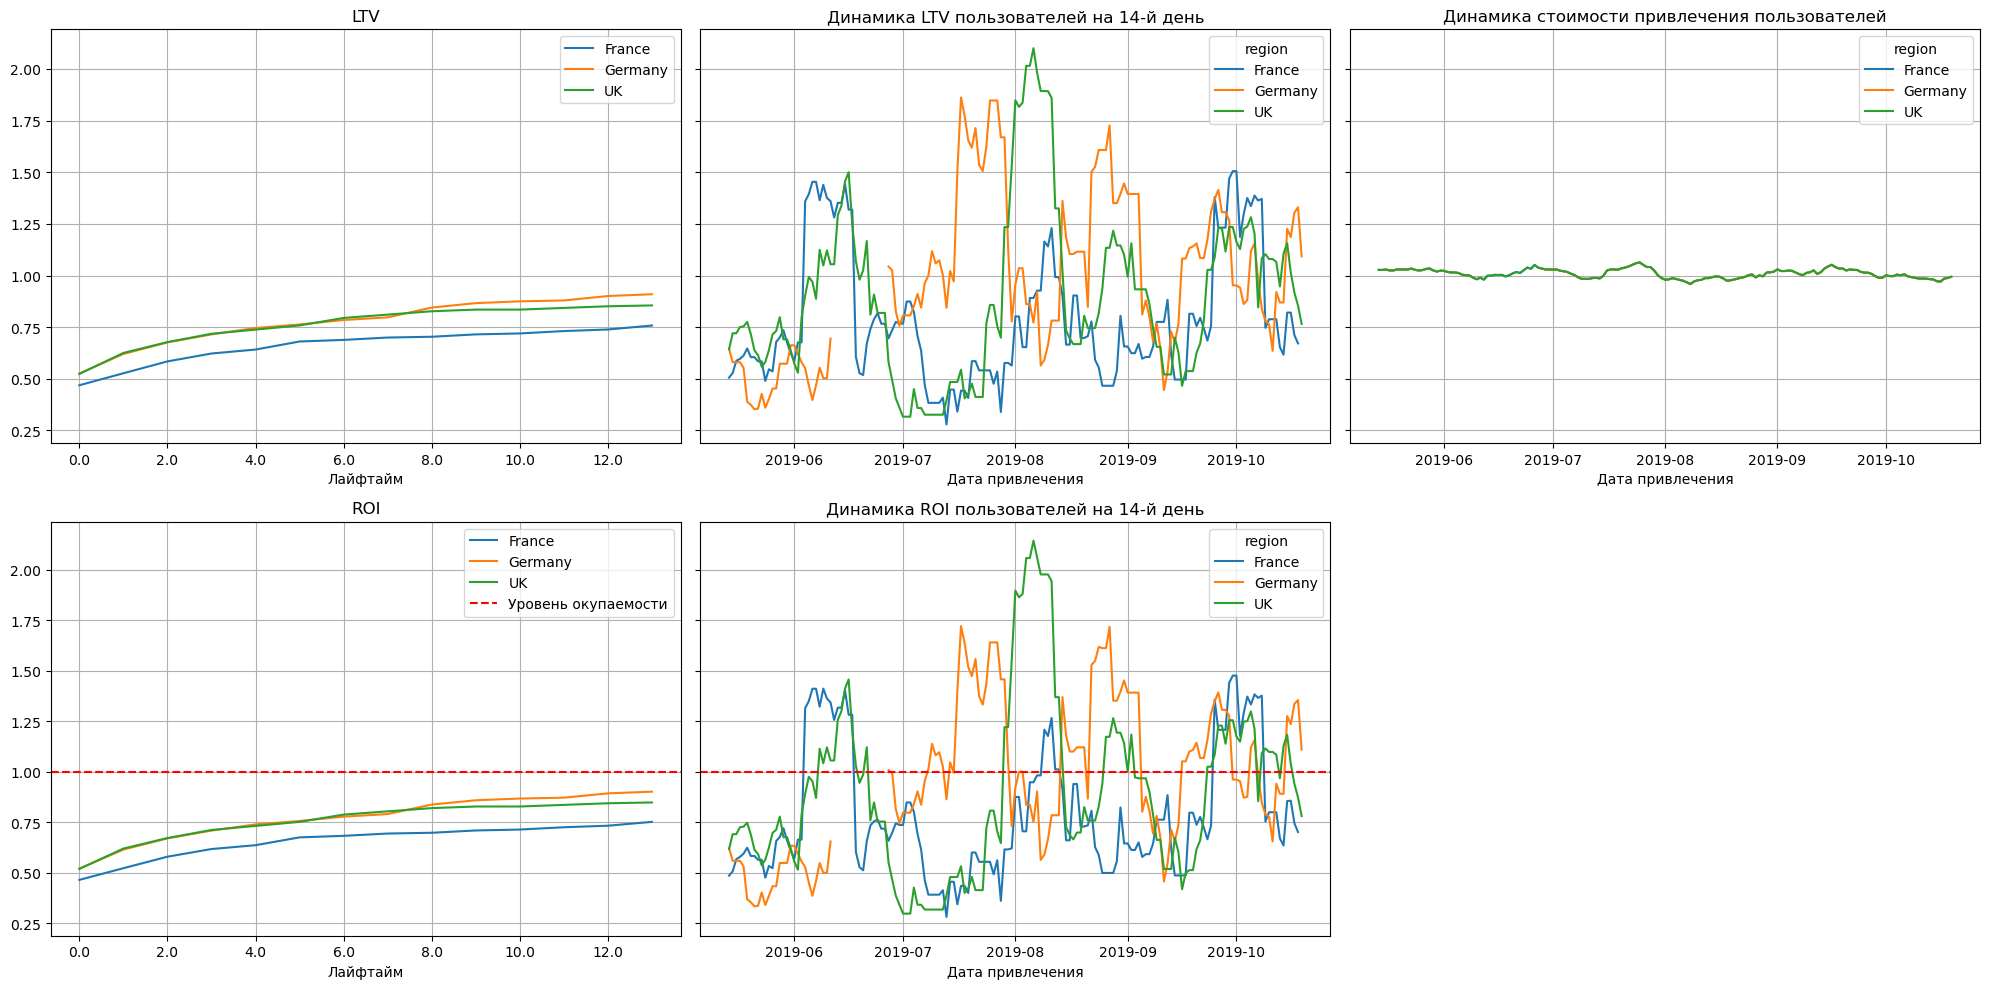

In [192]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, analysis_horizon, window=14)

Не окупается ни одна из стран.

In [187]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_ans,
    orders,
    observation_date,
    analysis_horizon,
    dimensions=['device'])

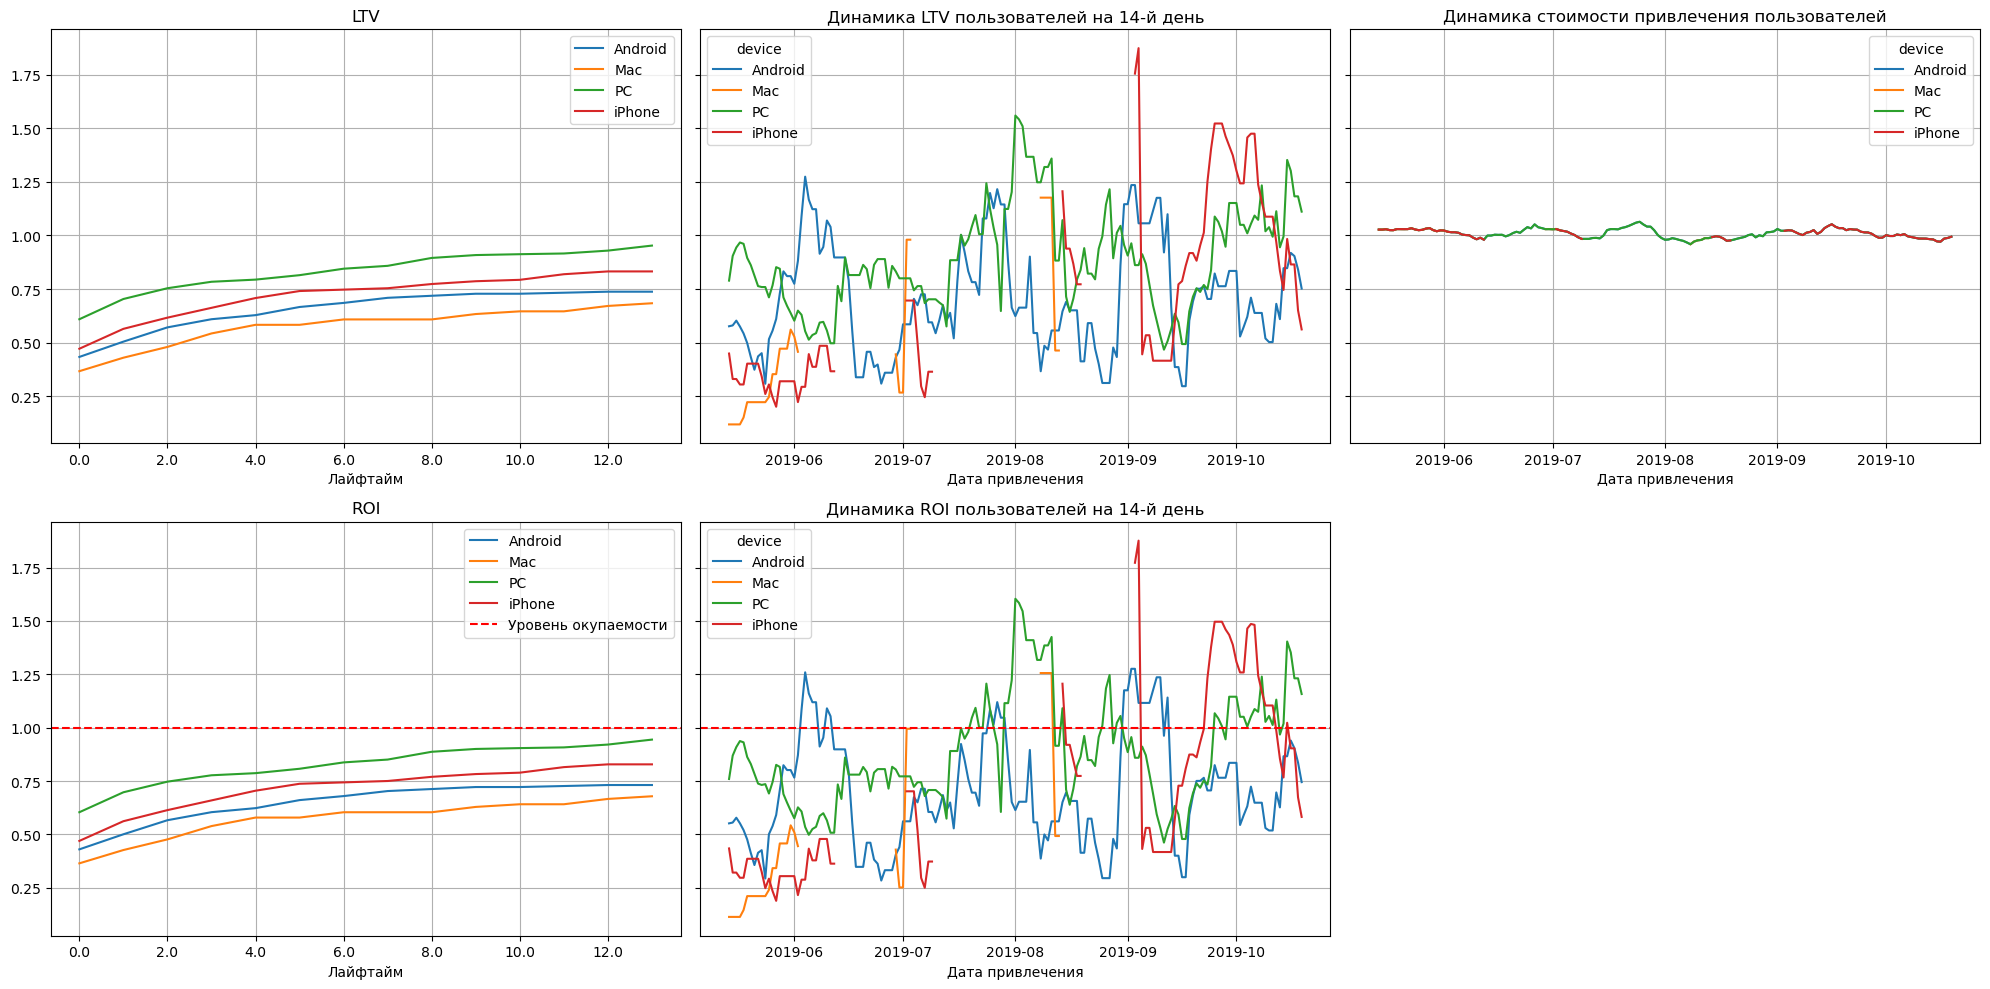

In [190]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, analysis_horizon, window=14)

ПК оказались близки к уровню окупаемости, но к 14 дню не дотянулись до него.

## Выводы

Основная причина неокупаемости рекламы - неадекватные траты на **невыгодные рекламные каналы FaceBoom и TipTop**. Эти каналы получают крупные бюджеты, но не отбивают их. Также не окупается канал AdNonSense, который работает с Европой. Это не такая существенная статья расходов, но всё же он неэффективен для всех стран и устройств.

Сейчас наша основная аудитория - США, и для этой страны есть 3 других рекламных канала: **YRabbit, MediaTornado и RocketSuperAds**, с отличными показателями окупаемости. Нам стоит **расширить сотрудничество с ними**. Если есть такая возможность, можно попробовать обсудить пересмотр условий сотрудничества с каналами FaceBoom и TipTop - если они согласятся на снижение цены в 2 раза, то сотрудничество с ними снова станет для нас выгодным. Также стоит отказаться от канала AdNonSense, если они не готовы на снижение цены на 30%.